# This code will train the model and save weights  using a data generator

First Import libraries

In [1]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [3]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [4]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [5]:
data_path_1 = r"C:\Users\UAB\data\Emory\data\\"
data_path_2 = r"C:\Users\UAB\data\KU\data\\"
data_path_3 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

images_1 = gather_set_and_path(data_path_1, '_M')
images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


images = images_1+images_2+images_3+images_4


print(len(images))



98922


In [6]:
print(len(images_1))
print(len(images_2))
print(len(images_3))
print(len(images_4))


23488
26082
42074
7278


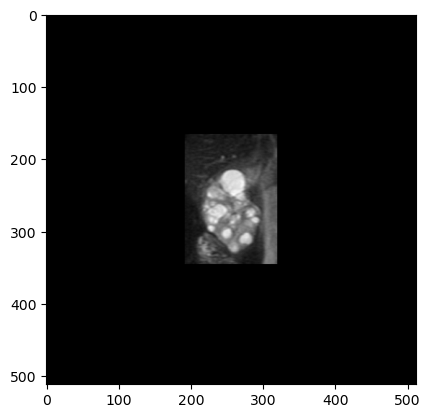

In [7]:
%matplotlib inline

image = np.load(images[-150])
plt.imshow(image, cmap='gray')

In [8]:
#kdata_path_1 = r"D:\EKS-predicted\80-10\\" 
masks_1 = gather_set_and_path(data_path_1, 'ep_K')
masks_2 = gather_set_and_path(data_path_2, 'ep_K')
masks_3 = gather_set_and_path(data_path_3, 'ep_K')
masks_4 = gather_set_and_path(data_path_4, 'ep_K')

masks = masks_1 + masks_2 + masks_3 + masks_4
#masks = gather_set_and_path(kdata_path_1, '_K')
print(len(masks))

77885


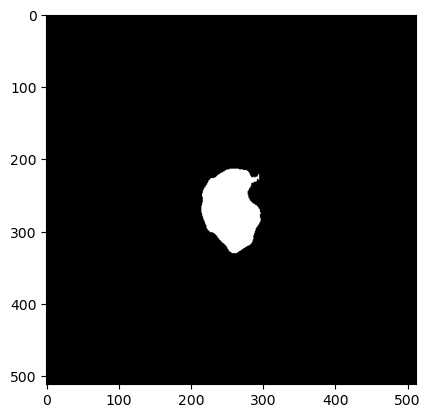

In [9]:
mask = np.load(masks[-150])
plt.imshow(mask, cmap='gray')

In [10]:

labels_1 = gather_set_and_path(data_path_1, '_C')
labels_2 = gather_set_and_path(data_path_2, '_C')
labels_3 = gather_set_and_path(data_path_3, '_C')
labels_4 = gather_set_and_path(data_path_4, '_C')

labels = labels_1 + labels_2 + labels_3 + labels_4

print(len(labels))


78257


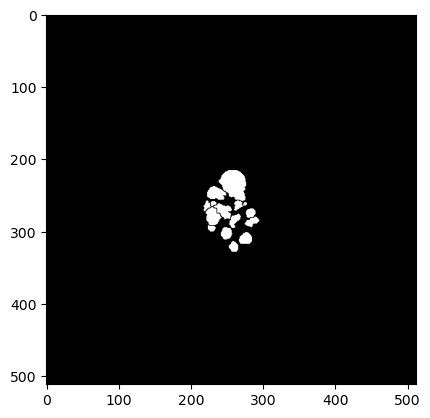

In [11]:
label = np.load(labels[-150])
plt.imshow(label, cmap='gray')

In [12]:
#print(masks[-1500])
print(images[-1500])
print(labels[-1500])
test_img = np.load(images[100])
print(test_img.shape, test_img.max(), test_img.min())
#test_msk = np.load(masks[100])
#print(test_msk.shape, test_msk.max(), test_msk.min())
test_lab = np.load(labels[100])
print(test_lab.shape, test_lab.max(), test_lab.min())


C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_M.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_C.npy
(512, 512) 129 0
(512, 512) 1 0


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [13]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [14]:
print(len(labels))

98922


In [15]:
import os
img_name = os.path.basename(images[0])[0:11]
print(img_name)

EM_200922_0


## Image separation for entire patient in training or validation - use with single set of images


In [16]:
from sklearn.model_selection import train_test_split


id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:11]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [17]:
print(len(unique_ids))

350


In [18]:
train, val = train_test_split(unique_ids, train_size = 0.8)

In [19]:
print(len(train))
print(len(val))

280
70


In [20]:
print(train[0:2])

['UB_414128_0', 'MA_343233_2']


In [21]:
#use this when images do not contain filepath:
#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

In [22]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train):
        train_list.append(images[i])

In [23]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val):
        val_list.append(images[i])

In [24]:
print(len(train_list))
print(len(val_list))
print(len(train_list)+len(val_list))
print(len(images))

61809
16076
77885
77885


In [25]:
partition = {'train':train_list, 'validation':val_list}

# Use for given csv file


In [16]:
import pandas as pd
df = pd.read_excel (r"C:\Users\UAB\Kidney-Segmentation-Jupyter\Data for AI development.xlsx", engine='openpyxl')

In [17]:
df = df.iloc[1: , 0:4]
df. columns=df. iloc[0] 

In [18]:
df2 = df.filter(regex='Validation')
df2 = df2.iloc[:,0].dropna()
val_csv_list = df2.values.tolist()
val_csv_list = val_csv_list[1:]

In [19]:
df3 = df.filter(regex='Training')
df3 = df3.iloc[:,0].dropna()
train_csv_list = df3.values.tolist()
train_csv_list = train_csv_list[1:]

In [20]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

151
439240L
19
419258L


In [21]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [22]:
id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:17]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [23]:
train_sets=[]
for i in range(len(train_csv_list)):
    phrase1 = train_csv_list[i][:-2]
    phrase2 = train_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                train_sets.append(name)
            else:
                continue
        else:
            continue

In [24]:
val_sets=[]
for i in range(len(val_csv_list)):
    phrase1 = val_csv_list[i][:-2]
    phrase2 = val_csv_list[i][-1]
    print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                val_sets.append(name)
            else:
                continue
        else:
            continue

41925 L
41925 R
26434 R
26517 L
26517 R
27168 L
27168 R
28393 L
37468 R
37625 L
37625 R
38016 L
17079 L
17079 R
17320 L
17320 R
17875 L
17875 R
18341 L


In [25]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [26]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])

In [27]:
print(len(train_list))
print(len(val_list))

76606
10547


In [30]:
partition = {'train':train_list, 'validation':val_list}

## Use for crossfold validation:

In [28]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [29]:
train_sets = ["KU_"]
val_sets = ["KU_"]

train_list_new = []
for i in range(len(train_list)):
    if any(phrase in train_list[i] for phrase in train_sets):
        train_list_new.append(train_list[i])


In [30]:
print(train_list_new[100])

C:\Users\UAB\data\KU\data\\KU_101934_0_96_R_13_M.npy


In [31]:
val_list_new = [] 
for i in range(len(val_list)):
    if any(phrase in val_list[i] for phrase in val_sets):
        val_list_new.append(val_list[i])


In [32]:
print(val_list_new[100])
print(len(train_list_new))
print(len(val_list_new))

C:\Users\UAB\data\KU\data\\KU_170795_0_81_R_27_M.npy
19800
3165


In [33]:
partition = {'train':train_list_new, 'validation':val_list_new}


# Create our data generators 

In [34]:

from Data_Gen_Mask import DataGeneratorK_Aug

In [35]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 2,
          'shuffle': True}
training_generator = DataGeneratorK_Aug(partition['train'], labels, **params)
validation_generator = DataGeneratorK_Aug(partition['validation'], labels, **params)

In [36]:
X, y = training_generator[5]
print(X.shape, y.shape)

(32, 512, 512, 2) (32, 512, 512, 2)


## View output

(512, 512) 173.0 0.0
(512, 512) 1.0 0.0


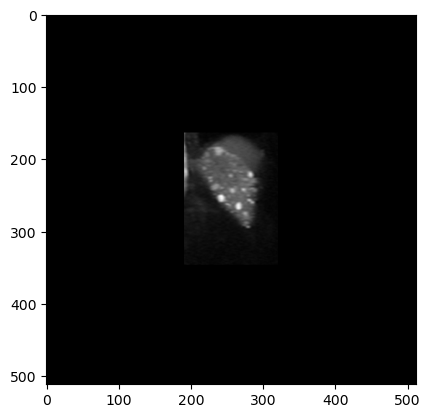

In [37]:
n=2
X_img = X[n,:,:,0]
X_msk =X[n,:,:,1] 
print(X_img.shape, X_img.max(), X_img.min())
print(X_msk.shape, X_msk.max(), X_msk.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

1.0

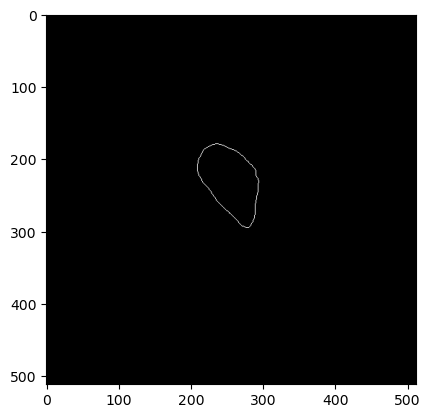

In [38]:
%matplotlib inline
plt.imshow(X_msk, cmap="gray")
X_msk.max()

(512, 512) 1.0 0.0


<Figure size 640x480 with 0 Axes>

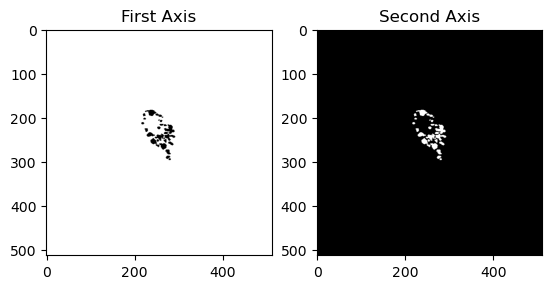

In [39]:
y_batch = y[n,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [40]:
model = custom_unet(input_shape=(512,512,2), num_classes=2)
#model.summary()

In [41]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [42]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
model_name = "Kansas_cyst_35ep.h5"
filepath = model_name
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
cb = TimingCallback()

In [43]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [44]:
# Train model on dataset
history = model.fit(training_generator, epochs = 35,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[cb])

Epoch 1/35
618/618 [==============================] - 1273s 2s/step - loss: 0.4594 - dice_coef: 0.7601 - val_loss: 0.1934 - val_dice_coef: 0.9005
Epoch 2/35
618/618 [==============================] - 1262s 2s/step - loss: 0.1510 - dice_coef: 0.9225 - val_loss: 0.0340 - val_dice_coef: 0.9827
Epoch 3/35
618/618 [==============================] - 1264s 2s/step - loss: 0.0566 - dice_coef: 0.9712 - val_loss: 0.0115 - val_dice_coef: 0.9942
Epoch 4/35
618/618 [==============================] - 1256s 2s/step - loss: 0.0250 - dice_coef: 0.9873 - val_loss: 0.0070 - val_dice_coef: 0.9964
Epoch 5/35
618/618 [==============================] - 1264s 2s/step - loss: 0.0135 - dice_coef: 0.9931 - val_loss: 0.0069 - val_dice_coef: 0.9965
Epoch 6/35
618/618 [==============================] - 1254s 2s/step - loss: 0.0092 - dice_coef: 0.9953 - val_loss: 0.0063 - val_dice_coef: 0.9968
Epoch 7/35
618/618 [==============================] - 1269s 2s/step - loss: 0.0072 - dice_coef: 0.9963 - val_loss: 0.0056 - 

In [45]:
from keras.models import Sequential, load_model
model.save(model_name)    

In [46]:
print(cb.logs)
print(sum(cb.logs))

[1272.9223315999998, 1262.0771420000003, 1264.0820037000003, 1255.8051282000001, 1264.1970104000002, 1253.7976344999997, 1268.8133656, 1274.1939343000013, 1277.9594766999999, 1295.5067948000014, 1274.4013360999998, 1279.3611433999995, 1255.2224248999992, 1242.6026493000027, 1239.8721970999977, 1242.7649492000019, 1250.7188983999986, 1245.0363761000008, 1242.907357, 1244.2223002000028, 1245.0672928999993, 1242.6735626000009, 1243.5763203999995, 1240.5466314999976, 1242.1132400000024, 1242.638880800001, 1242.7962256000028, 1266.4067151999989, 1243.630660200004, 1242.0455790999986, 1242.5763115000009, 1241.1920337000047, 1245.0660621999996, 1240.5804118000015, 1253.8801916999946]
43881.25457270001


In [47]:
sum(cb.logs)/3600

12.189237381305558

In [48]:
time = list(cb.logs)
print(time)

[1272.9223315999998, 1262.0771420000003, 1264.0820037000003, 1255.8051282000001, 1264.1970104000002, 1253.7976344999997, 1268.8133656, 1274.1939343000013, 1277.9594766999999, 1295.5067948000014, 1274.4013360999998, 1279.3611433999995, 1255.2224248999992, 1242.6026493000027, 1239.8721970999977, 1242.7649492000019, 1250.7188983999986, 1245.0363761000008, 1242.907357, 1244.2223002000028, 1245.0672928999993, 1242.6735626000009, 1243.5763203999995, 1240.5466314999976, 1242.1132400000024, 1242.638880800001, 1242.7962256000028, 1266.4067151999989, 1243.630660200004, 1242.0455790999986, 1242.5763115000009, 1241.1920337000047, 1245.0660621999996, 1240.5804118000015, 1253.8801916999946]


In [49]:
import pandas as pd
df = pd.DataFrame.from_dict(history.history)

In [50]:
df['epoch_time'] = np.array(cb.logs)

In [51]:
df.to_csv('cyst_seg_kansas_35epoch_1.25.23.csv')

In [55]:
import pandas as pd

DF = pd.read_csv('cyst_seg_80-10_split_10epoch_corrected.csv')

print(DF) 

FileNotFoundError: [Errno 2] No such file or directory: 'cyst_seg_80-10_split_10epoch_corrected.csv'

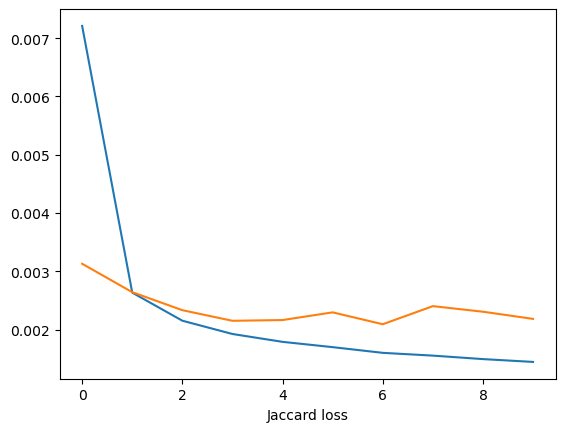

In [102]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

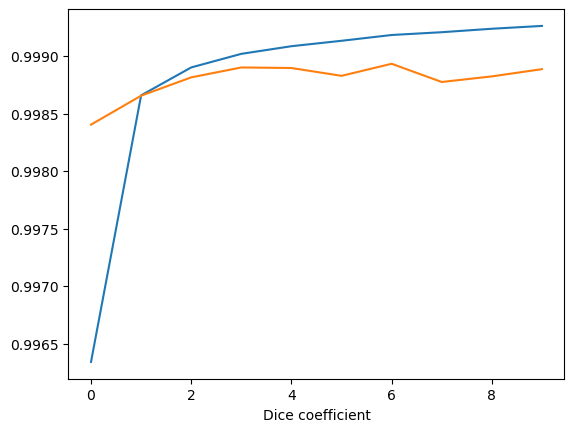

In [103]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')